In [1]:
import numpy as np
from torch_geometric.datasets import Planetoid
from sklearn.decomposition import PCA
from torch_geometric.data import ClusterData
from torch_geometric.loader import ClusterLoader
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import to_dense_adj, get_laplacian
from scipy import linalg
import seaborn as sbs
from scipy.stats import wasserstein_distance 

In [2]:
dataset = Planetoid(root='../dataset/Cora', name='Cora')
graph = dataset[0]
# PCA transform the sparse features
pca = PCA(n_components=32)
pca = pca.fit(graph.x.numpy())

In [3]:
partition_size = 256
cluster_data = ClusterData(graph, num_parts=graph.x.size(0)//partition_size, recursive=False)
cluster_loader = ClusterLoader(cluster_data, batch_size=1, shuffle=False, drop_last=False, num_workers=0)

c:\users\mucong ding\research\sublinear-gnn\env\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
Computing METIS partitioning...
Done!


In [4]:
def scatter_plot_pca(X_pca, y):
    plt.figure(figsize=(10, 8))
    plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=y)
    plt.xlabel("PCA Feature 1", fontsize=14)
    plt.ylabel("PCA Feature 2", fontsize=14)
    plt.colorbar()
    plt.show()
    
def get_topology_matrices(graph):
    # adjacency matrix
    A = to_dense_adj(graph.edge_index, batch=None, edge_attr=None, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    # symmetric normalized laplacian
    L_edge_index, L_edge_weight = get_laplacian(graph.edge_index, edge_weight=None, normalization="sym",
                                                num_nodes=graph.x.size(0))
    L = to_dense_adj(L_edge_index, batch=None, edge_attr=L_edge_weight, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    # GCN convolution matrix
    C_edge_index, C_edge_weight = gcn_norm(graph.edge_index, edge_weight=None, 
                                           num_nodes=graph.x.size(0), improved=False, add_self_loops=True)
    C = to_dense_adj(C_edge_index, batch=None, edge_attr=C_edge_weight, max_num_nodes=graph.x.size(0)).squeeze().numpy()
    return A, L, C

def get_eigen_system(L):
    freqs, U = linalg.eigh(L)
    # clip numerical errors
    freqs = np.clip(freqs, 0, 2)
    return freqs, U

def spectral_magnitude(X, U):
    X_spec = U.transpose() @ X
    return np.linalg.norm(X_spec, axis=1)

def plot_magnitude(freqs, spec_mag, smooth_width=0.1):
    #plt.figure(figsize=(10,6))
    plt.plot(freqs, spec_mag, label="Input Magnitude", color='#1f77b4')
    #smoothed_spec_mag = savgol_filter(spec_mag, int(len(freqs)*smooth_width), 1)
    #plt.plot(freqs, smoothed_spec_mag, label="Smoothed Mean", color='#ff7f0e')
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Input Magnitude", fontsize=14)
    plt.xlim([0, 2])
    #plt.show()
    
def gcn_spectral_filtering(C, X_in, nlayer=1, activation="ReLU", nrepeat=1):
    assert activation in ["ReLU", "sigmoid", None]
    if activation == "ReLU":
        sigma = lambda x: np.maximum(x, 0)
    elif activation == "sigmoid":
        sigma = lambda x: 1/(1 + np.exp(-x))
    elif activation is None:
        sigma = lambda x: x
    else:
        assert False
    nfeature = X_in.shape[1]
    X_out = np.zeros_like(X_in)
    for _ in range(nrepeat):
        X = X_in
        for l in range(nlayer):
            W = np.random.randn(nfeature, nfeature)/np.sqrt(nfeature)
            X = sigma(C @ X @ W)
        X_out += X
    return X_out/nrepeat

def plot_response(spec_mag_out, spec_mag_out_std, spec_mag_in, pred_responses):
    plt.figure(figsize=(10,6))
    plt.plot(freqs, spec_mag_out/spec_mag_in)
    plt.plot(freqs, pred_responses)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Spectral Response (Relative Magnitude)", fontsize=14)
    plt.xlim([0, 2])
    plt.ylim([0, 1])
    plt.show()

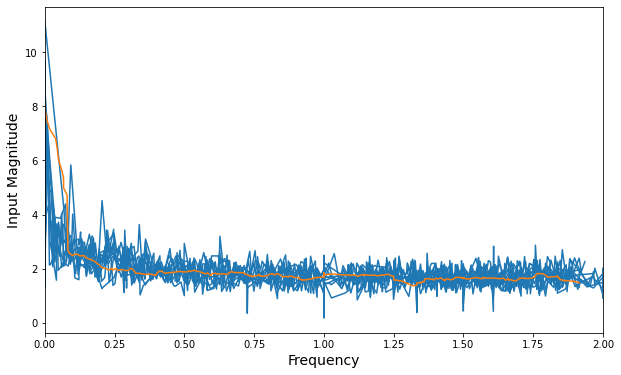

In [5]:
plt.figure(figsize=(10,6))
for count, cluster_graph in enumerate(cluster_loader):
    X_pca = pca.transform(cluster_graph.x.numpy())
    y = cluster_graph.y.numpy()
    A, L ,C = get_topology_matrices(cluster_graph)
    freqs, U = get_eigen_system(L)
    spec_mag = spectral_magnitude(X_pca, U)
    plot_magnitude(freqs, spec_mag)
    if count >= 9:
        smoothed_spec_mag = savgol_filter(spec_mag, int(len(freqs)*0.05), 1)
        smoothed_spec_mag[:10] = smoothed_spec_mag[:10] + 2
        plt.plot(freqs, smoothed_spec_mag, label="Smoothed Mean", color='#ff7f0e')
        break
plt.show()

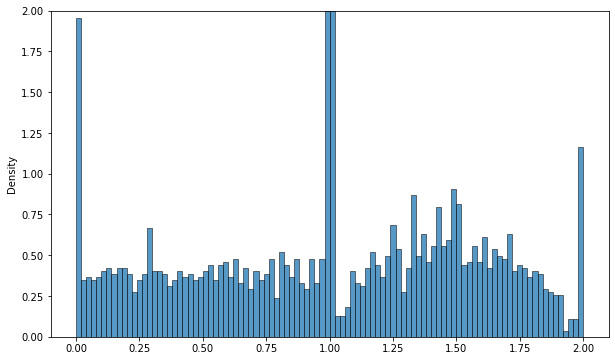

In [6]:
freqs_all = []
for count, cluster_graph in enumerate(cluster_loader):
    X_pca = pca.transform(cluster_graph.x.numpy())
    y = cluster_graph.y.numpy()
    A, L ,C = get_topology_matrices(cluster_graph)
    freqs, U = get_eigen_system(L)
    freqs_all.extend(freqs)
    if count >= 10:
        break
fig, ax = plt.subplots(figsize=(10,6))
sbs.histplot(freqs_all, stat='density', bins=100, ax=ax)
ax.set_ylim([0, 2])
plt.show()

c:\users\mucong ding\research\sublinear-gnn\env\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!


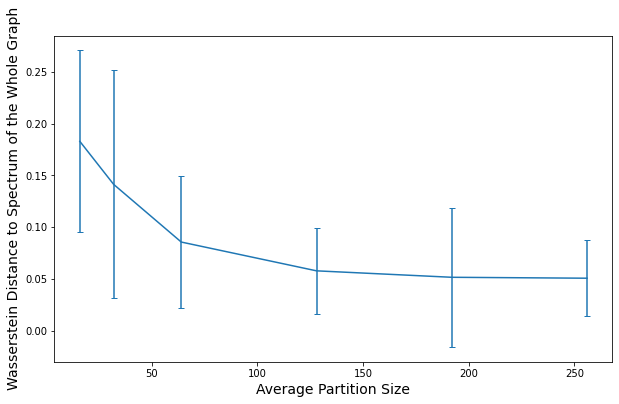

In [25]:
freqs_whole = get_eigen_system(get_topology_matrices(graph)[1])[0]
partition_sizes = np.array([16, 32, 64, 128, 192, 256])
wds_mean = []
wds_std = []
for count, partition_size in enumerate(partition_sizes):
    cluster_data = ClusterData(graph, num_parts=graph.x.size(0)//partition_size, recursive=False)
    cluster_loader = ClusterLoader(cluster_data, batch_size=1, shuffle=False, drop_last=False, num_workers=0)
    wds = []
    for cluster_graph in cluster_loader:
        freqs = get_eigen_system(get_topology_matrices(cluster_graph)[1])[0]
        wds.append(wasserstein_distance(freqs_whole, freqs))
    wds = np.array(wds)[:10]
    wds_mean.append(np.mean(wds))
    wds_std.append(np.std(wds))
    
plt.figure(figsize=(10,6))
plt.errorbar(partition_sizes, wds_mean, yerr=wds_std, capsize=3)
plt.ylabel("Wasserstein Distance to Spectrum of the Whole Graph", fontsize=14)
plt.xlabel("Average Partition Size", fontsize=14)
#plt.xlim([0, 2])
#plt.ylim([0, 1])
plt.show()